In [ ]:
!pip install -U git+https://github.com/huggingface/diffusers.git bitsandbytes

In [ ]:
!git clone https://github.com/camlhui/inpainting-review.git

In [ ]:
%cd /content/inpainting-review
!git pull

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

os.environ['DATA_DIR'] = '/content/drive/MyDrive/Colab storage/inpainting-review'
os.environ["HUGGING_FACE_CACHE_DIR"] = '/content/drive/MyDrive/Colab storage/hugging-face-cache'

In [5]:
import os
from google.colab import userdata


hf_hub_token = userdata.get("HUGGING_FACE_HUB_TOKEN")
assert hf_hub_token, "missing Google colab secret HUGGING_FACE_HUB_TOKEN"

os.environ["HUGGING_FACE_HUB_TOKEN"] = hf_hub_token

In [6]:
%cd /content/inpainting-review/src

import json
import os
from inpainting_review.models import InpaintingTask
from inpainting_review.utils.image import load_and_preprocess_image, load_and_preprocess_mask


with open("inpainting_review/tasks.json") as f:
    tasks = [InpaintingTask(**t) for t in json.load(f)["tasks"]]

image = load_and_preprocess_image(os.path.join(os.environ['DATA_DIR'], tasks[0].source_image))
mask = load_and_preprocess_mask(os.path.join(os.environ['DATA_DIR'], tasks[0].mask_image))
prompt = tasks[0].prompt

/content/inpainting-review/src


# FLUX.1-Fill-dev

https://huggingface.co/black-forest-labs/FLUX.1-Fill-dev

In [ ]:
import torch
from diffusers import FluxFillPipeline

pipe = (
    FluxFillPipeline
    .from_pretrained(
        "black-forest-labs/FLUX.1-Fill-dev",
        torch_dtype=torch.bfloat16
    )
    .to("cuda")
)

  0%|          | 0/50 [00:00<?, ?it/s]

(-0.5, 1231.5, 1631.5, -0.5)

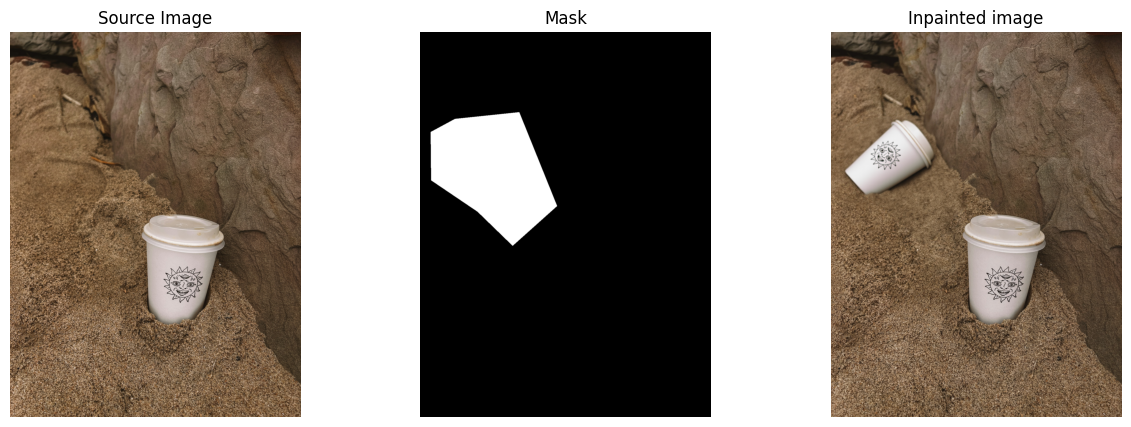

In [7]:
from diffusers.utils import load_image
import matplotlib.pyplot as plt
%matplotlib inline


image = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup.png")
mask = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup_mask.png")

inpainted_image = pipe(
    prompt="a white paper cup",
    image=image,
    mask_image=mask,
    height=1632,
    width=1232,
    guidance_scale=30,
    num_inference_steps=50,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(inpainted_image)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time


model_name = "black-forest-labs/FLUX.1-Fill-dev".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image))
        prompt = task.prompt

        inpainted_image = pipe(
            prompt=prompt,
            image=image,
            mask_image=mask,
            height=image.size[1],
            width=image.size[0],
            guidance_scale=30,
            num_inference_steps=50,
            max_sequence_length=512,
            generator=generator
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)

# FLUX.1-Fill-dev-nf4

https://huggingface.co/sayakpaul/FLUX.1-Fill-dev-nf4

In [ ]:
from diffusers import DiffusionPipeline, FluxFillPipeline, FluxTransformer2DModel
import torch
from transformers import T5EncoderModel


orig_pipeline = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-Fill-dev", torch_dtype=torch.bfloat16)

transformer = FluxTransformer2DModel.from_pretrained(
    "sayakpaul/FLUX.1-Fill-dev-nf4", subfolder="transformer", torch_dtype=torch.bfloat16
)
text_encoder_2 = T5EncoderModel.from_pretrained(
    "sayakpaul/FLUX.1-Fill-dev-nf4", subfolder="text_encoder_2", torch_dtype=torch.bfloat16
)
pipeline = FluxFillPipeline.from_pipe(
    orig_pipeline, transformer=transformer, text_encoder_2=text_encoder_2, torch_dtype=torch.bfloat16
)

pipeline.enable_model_cpu_offload()
pipeline.remove_all_hooks()
pipeline = pipeline.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

(-0.5, 1231.5, 1631.5, -0.5)

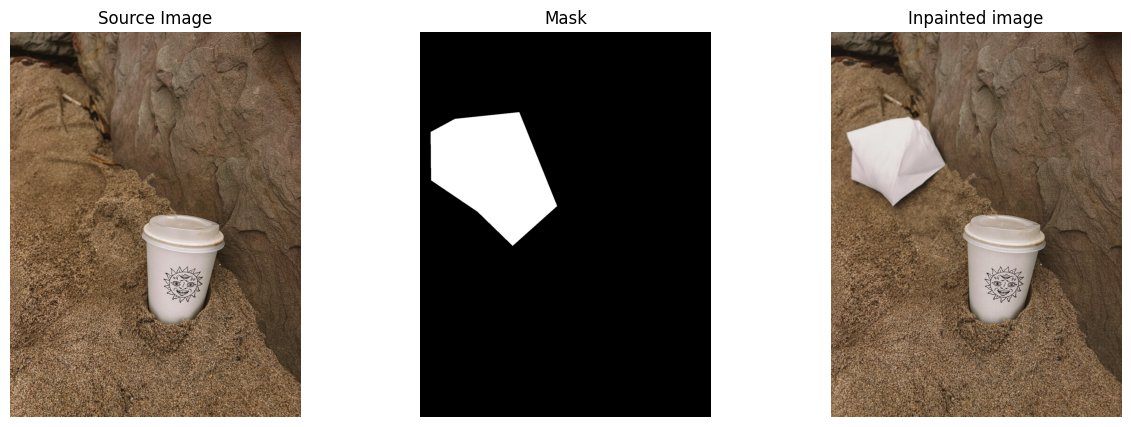

In [9]:
from diffusers.utils import load_image
import matplotlib.pyplot as plt
%matplotlib inline


image = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup.png")
mask = load_image("https://huggingface.co/datasets/diffusers/diffusers-images-docs/resolve/main/cup_mask.png")

inpainted_image = pipeline(
    prompt="a white paper cup",
    image=image,
    mask_image=mask,
    height=1632,
    width=1232,
    guidance_scale=30,
    num_inference_steps=50,
    max_sequence_length=512,
    generator=torch.Generator("cuda").manual_seed(0)
).images[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(inpainted_image)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time


model_name = "sayakpaul/FLUX.1-Fill-dev-nf4".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image))
        prompt = task.prompt

        inpainted_image = pipeline(
            prompt=prompt,
            image=image,
            mask_image=mask,
            height=image.size[1],
            width=image.size[0],
            guidance_scale=30,
            num_inference_steps=50,
            max_sequence_length=512,
            generator=generator
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)

# FLUX.1-dev-Controlnet-Inpainting-Beta

https://huggingface.co/alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Beta

In [ ]:
%cd /content
!git clone https://github.com/alimama-creative/FLUX-Controlnet-Inpainting.git

In [ ]:
!pip install diffusers==0.30.2

In [8]:
%cd /content/FLUX-Controlnet-Inpainting

/content/FLUX-Controlnet-Inpainting


In [ ]:
import torch
from controlnet_flux import FluxControlNetModel
from transformer_flux import FluxTransformer2DModel
from pipeline_flux_controlnet_inpaint import FluxControlNetInpaintingPipeline


controlnet = FluxControlNetModel.from_pretrained("alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Beta", torch_dtype=torch.bfloat16)
transformer = FluxTransformer2DModel.from_pretrained(
        "black-forest-labs/FLUX.1-dev", subfolder='transformer', torch_dtype=torch.bfloat16
    )
pipe = FluxControlNetInpaintingPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    controlnet=controlnet,
    transformer=transformer,
    torch_dtype=torch.bfloat16
).to("cuda")
pipe.transformer.to(torch.bfloat16)
pipe.controlnet.to(torch.bfloat16)

  0%|          | 0/28 [00:00<?, ?it/s]

(-0.5, 767.5, 767.5, -0.5)

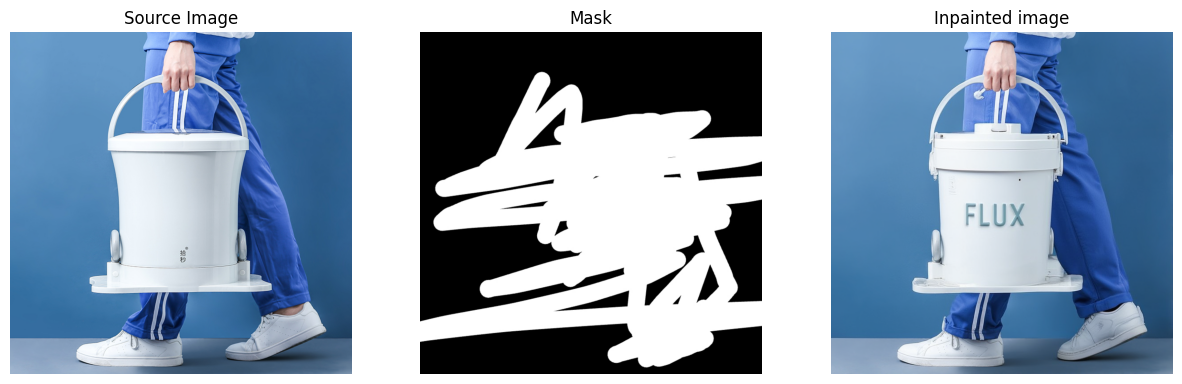

In [15]:
from diffusers.utils import load_image
import matplotlib.pyplot as plt
%matplotlib inline

# Set image path , mask path and prompt
image_path='https://huggingface.co/alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha/resolve/main/images/bucket.png'
mask_path='https://huggingface.co/alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha/resolve/main/images/bucket_mask.jpeg'
prompt='a person wearing a white shoe, carrying a white bucket with text "FLUX" on it'

# Load image and mask
size = (768, 768)
image = load_image(image_path).convert("RGB").resize(size)
mask = load_image(mask_path).convert("RGB").resize(size)
generator = torch.Generator(device="cuda").manual_seed(24)

# Inpaint
result = pipe(
    prompt=prompt,
    height=size[1],
    width=size[0],
    control_image=image,
    control_mask=mask,
    num_inference_steps=28,
    generator=generator,
    controlnet_conditioning_scale=0.9,
    guidance_scale=3.5,
    negative_prompt="",
    true_guidance_scale=1.0 # default: 3.5 for alpha and 1.0 for beta
).images[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time


model_name = "alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Beta".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image))
        prompt = task.prompt

        inpainted_image = pipe(
            prompt=task.prompt,
            height=image.size[1],
            width=image.size[0],
            control_image=image,
            control_mask=mask,
            num_inference_steps=28,
            generator=generator,
            controlnet_conditioning_scale=0.9,
            guidance_scale=3.5,
            negative_prompt=task.negative_prompt,
            true_guidance_scale=1.0 # default: 3.5 for alpha and 1.0 for beta
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)

# FLUX.1-dev-Controlnet-Inpainting-Beta-Turbo

https://huggingface.co/alimama-creative/FLUX.1-Turbo-Alpha

In [6]:
%cd /content
!git clone https://github.com/alimama-creative/FLUX-Controlnet-Inpainting.git

/content
Cloning into 'FLUX-Controlnet-Inpainting'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 84 (delta 40), reused 30 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 2.26 MiB | 13.70 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [ ]:
!pip install diffusers==0.30.2

In [ ]:
%cd /content/FLUX-Controlnet-Inpainting

In [ ]:
import torch
from controlnet_flux import FluxControlNetModel
from transformer_flux import FluxTransformer2DModel
from pipeline_flux_controlnet_inpaint import FluxControlNetInpaintingPipeline


controlnet = FluxControlNetModel.from_pretrained("alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Beta", torch_dtype=torch.bfloat16)
transformer = FluxTransformer2DModel.from_pretrained(
        "black-forest-labs/FLUX.1-dev", subfolder='transformer', torch_dtype=torch.bfloat16
    )
pipe = FluxControlNetInpaintingPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    controlnet=controlnet,
    transformer=transformer,
    torch_dtype=torch.bfloat16
)

pipe.transformer.to(torch.bfloat16)
pipe.controlnet.to(torch.bfloat16)

pipe.load_lora_weights("alimama-creative/FLUX.1-Turbo-Alpha")
pipe.fuse_lora()

In [ ]:
pipe.to('cuda')

  0%|          | 0/8 [00:00<?, ?it/s]

(-0.5, 1023.5, 1023.5, -0.5)

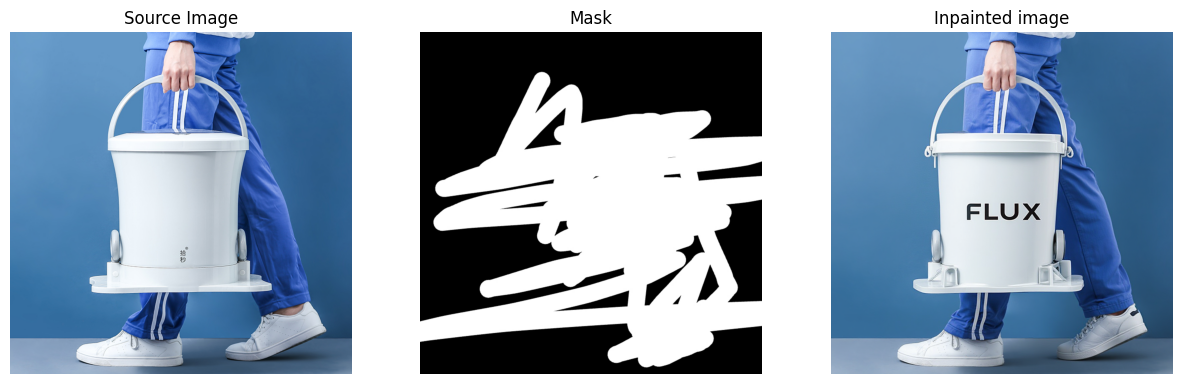

In [18]:
from diffusers.utils import load_image
import matplotlib.pyplot as plt
%matplotlib inline

# Set image path , mask path and prompt
image_path='https://huggingface.co/alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha/resolve/main/images/bucket.png'
mask_path='https://huggingface.co/alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha/resolve/main/images/bucket_mask.jpeg'
prompt='a person wearing a white shoe, carrying a white bucket with text "FLUX" on it'

# Load image and mask
size = (1024, 1024)
image = load_image(image_path).convert("RGB").resize(size)
mask = load_image(mask_path).convert("RGB").resize(size)
generator = torch.Generator(device="cpu").manual_seed(24)

# Inpaint
result = pipe(
    prompt=prompt,
    height=size[1],
    width=size[0],
    control_image=image,
    control_mask=mask,
    num_inference_steps=8,
    generator=generator,
    controlnet_conditioning_scale=0.9,
    guidance_scale=3.5,
    negative_prompt="",
    true_guidance_scale=1.0 # default: 3.5 for alpha and 1.0 for beta
).images[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(result)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time



model_name = "alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Beta-Turbo".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        torch.cuda.empty_cache()

        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image))
        prompt = task.prompt

        inpainted_image = pipe(
            prompt=task.prompt,
            height=image.size[1],
            width=image.size[0],
            control_image=image,
            control_mask=mask,
            num_inference_steps=8,
            generator=generator,
            controlnet_conditioning_scale=0.9,
            guidance_scale=3.5,
            negative_prompt=task.negative_prompt,
            true_guidance_scale=1.0 # default: 3.5 for alpha and 1.0 for beta
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)